In [3]:
from IPython.display import display, HTML
display(HTML("<style>:root {--jp-notebook-max-width: 3000px;}</style>"))
display(HTML("<style>.container { width:100% !important; }</style>"))

%config Completer.user_jedi = False

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split 

# 기계학습 (60점)

#### ✅ 2023년도 NBA 농구 슛 시도 관련 데이터 

In [9]:
df = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE/refs/heads/main/ADP_SET2/data/nba.csv')

df.head()

,TEAM_NAME,PLAYER_ID,POSITION_GROUP,GAME_ID,SHOT_MADE,ACTION_TYPE,SHOT_TYPE,ZONE_ABB,LOC_X,LOC_Y,QUARTER,MINS_LEFT,SECS_LEFT
0,team_5,player_1,G,22300003,False,Driving Floating Jump Shot,2PT Field Goal,C,-0.4,17.45,1,11,1
1,team_5,player_2,F,22300003,True,Jump Shot,3PT Field Goal,C,1.5,30.55,1,10,26
2,team_5,player_3,G,22300003,True,Driving Layup Shot,2PT Field Goal,C,-3.3,6.55,1,9,46
3,team_5,player_1,G,22300003,True,Running Finger Roll Layup Shot,2PT Field Goal,C,-1.0,5.85,1,8,30
4,team_5,player_3,G,22300003,True,Cutting Layup Shot,2PT Field Goal,C,-0.0,6.25,1,8,8


### ✅ 전처리
- 1. shot_distance (슛거리)     : LOC_X, LOX_Y 좌표의 제곱합에 루트를 씌운다
- 2. net_play_time (경기경과시간) : 슛을 시도한 시점의 순 경기 시간을 초(sec)단위로 구한다. 쉬는시간은 고려하지 않는다. 4쿼터 종료시점(MINS_LEFT =0, SECS_LEFT=0)에 슛을 시도했다면 2880 값을 가져야 한다. 
- 3. net_score : 해당 게임에 해당팀이 슛을 쏜 결과를 반영한 누적 득점

In [12]:
# 1) 
df['shot_distance'] = np.sqrt(df['LOC_X'] **2  + df['LOC_Y'] ** 2)

# 2) 
df['net_play_time'] = df['QUARTER'] * 12 * 60 - df['MINS_LEFT'] * 60 - df['SECS_LEFT']

In [32]:
# 3) net_score 
df['SHOT_MADE_NUM'] = df['SHOT_MADE'].astype(str).apply(lambda x : 1 if x == 'True'else 0).astype(int)

df['SHOT_TYPE_NUM'] = df['SHOT_TYPE'].str.split('PT').str[0].astype(int)

df['score'] = df['SHOT_MADE_NUM'] * df['SHOT_TYPE_NUM']

# 게임, 팁별 누적 score점수
df['net_score'] = df.groupby(['GAME_ID','TEAM_NAME'])['score'].cumsum()


##### ✅ 데이터 EDA를 실시하라 (시각화 포함)

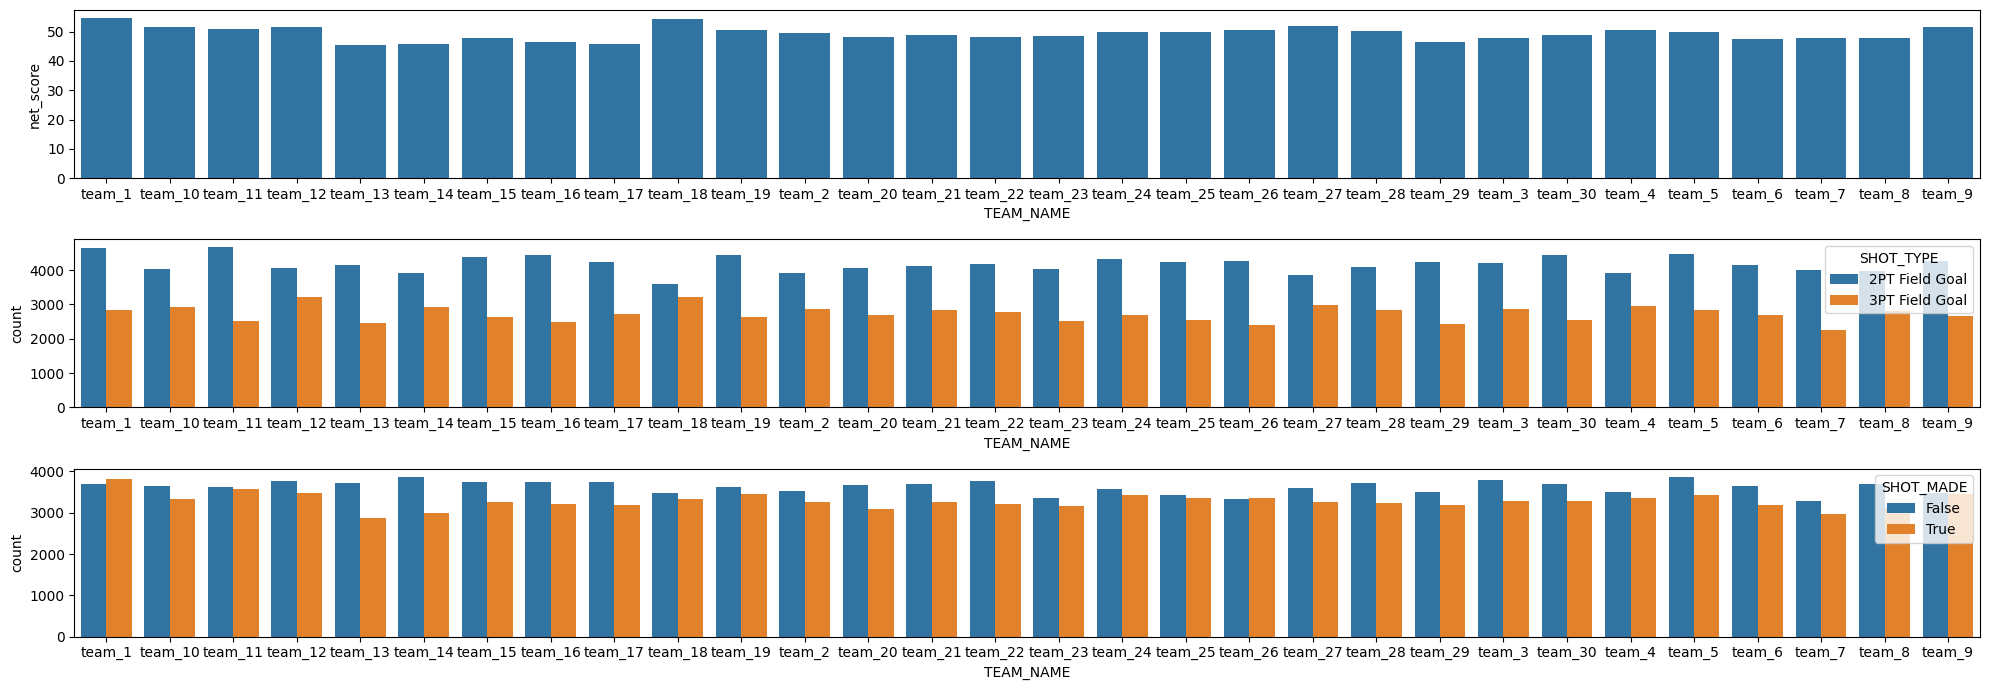

In [38]:
# 팀별 net_score, shot_type , shot_made 
cols = ['net_score','SHOT_TYPE','SHOT_MADE']

fig, axes = plt.subplots(3,1, figsize = (20, 7))

for i , axes in enumerate(axes.flat[: len(cols)]) : 
    col_i = df[cols].columns[i] 
    if col_i == 'net_score' :
        target = df.groupby(['TEAM_NAME'])[col_i].mean().reset_index()
        sns.barplot(x = 'TEAM_NAME', y = col_i, data = target , ax = axes) 
    else : 
        target = df.groupby(['TEAM_NAME'])[col_i].value_counts().reset_index()
        sns.barplot(x = 'TEAM_NAME', y ='count', hue = col_i, data = target, ax = axes)

plt.tight_layout()
plt.show()

#### ✅ 기계학습3     
3쿼터까지의 데이터를 바탕으로 승부를 예측하는 분류 모델을 만들려고 한다.
데이터를 아래 기준으로 전처리 진행한다.

1. 1각 행은 하나의 팀, 하나의 게임 아이디에 대한 정보를 나타낸다.
2. 각 쿼터(1~3쿼터)를 6분간격으로 두 구간으로 나누어 새로운 파생변수를 만든다.      
    - 1_1_try (1쿼터의 0~6분)의 2점 실패 횟수)(1_1_try_2) , 3점 실패 횟수 (1_1_try_3)
    - 1_2_try (1쿼터의 6~12분)의 2점 실패 횟수 (1_1_try_2) ,3점 실패 횟수 (1_1_try_3)
    - ~ 3쿼터까지 총 6구간에 대해 12개의 컬럼
3.  해당 게임의 팀별 1쿼터까지 득점, 3쿼터까지의 총 득점(2,3점) (총 2개컬럼, 1_q_score , 3_q_score)
4.  4쿼터 후 최종 승패여부(result) (승 : 1 , 패 :0 ) - 자유투는 없다고 가정, 2,3점 만으로 게임의 승부를 결정, 승부가 결정나지 않은 게임은 없다

In [61]:
# 2) failer_df 

# 0-6 / 6- 12분 나누기 
# STEP 1) 1,2,3,4의 쿼터를 각각 12 * 60 = 720 기준으로 - MINS_LEFT - SECS_LEFT 를 나누어서 각 쿼터당 초를 다시 환산
df['minute6'] = 720 - df['MINS_LEFT'] * 60 - df['SECS_LEFT']

# STEP 2) 1~3 쿼터 & 실패한 내용만 추출 
fail = df[(df['QUARTER'].isin([1,2,3])) & (df['SHOT_MADE'] == False)].reset_index(drop = True) 

# STEP 3) 361 이하는 1 , 아니면 2 
fail['q_12'] = fail['minute6'].apply(lambda x : '1' if x < 361 else '2')

# STEP 4) category 만들어주기 
fail['category'] = fail['QUARTER'].astype(str) + '_' + fail['q_12'].astype(str) + '_try_' + fail['SHOT_TYPE_NUM'].astype(str)

# STEP 5) Pivoting 
pivot_df = fail[['GAME_ID','TEAM_NAME','category']].pivot_table(index = ['GAME_ID','TEAM_NAME'], columns = 'category', aggfunc ='size')

# STEP 6) fillna 
pivot_df = pivot_df.fillna(0)
pivot_df = pivot_df.reset_index()
pivot_df.head(5)

category,GAME_ID,TEAM_NAME,1_1_try_2,1_1_try_3,1_2_try_2,1_2_try_3,2_1_try_2,2_1_try_3,2_2_try_2,2_2_try_3,3_1_try_2,3_1_try_3,3_2_try_2,3_2_try_3
0,22300001,team_1,5.0,2.0,3.0,1.0,3.0,1.0,2.0,3.0,4.0,3.0,4.0,3.0
1,22300001,team_2,5.0,2.0,2.0,3.0,3.0,2.0,1.0,5.0,3.0,1.0,1.0,1.0
2,22300002,team_3,7.0,3.0,7.0,3.0,0.0,5.0,7.0,3.0,0.0,6.0,0.0,5.0
3,22300002,team_4,1.0,1.0,6.0,4.0,4.0,3.0,4.0,0.0,3.0,3.0,4.0,3.0
4,22300003,team_5,1.0,0.0,1.0,2.0,6.0,1.0,2.0,4.0,3.0,3.0,1.0,1.0


In [84]:
# 해당 게임의 팀별 1쿼터까지 득점, 3쿼터까지의 총 득점(2,3점) (총 2개컬럼, 1_q_score , 3_q_score)

# STEP 1) 1, 3쿼터만 추출 
q13 = df[df['QUARTER'].isin([1,3])].reset_index(drop = True)

# STEP 2) 1,3 쿼터별 최대값 산출  
max_13 = q13.groupby(['GAME_ID','TEAM_NAME','QUARTER'])['net_score'].max().reset_index() 
max_13.head()


# STEP 3) Pivoting 
pivot_13 = max_13.pivot_table(index = ['GAME_ID','TEAM_NAME'] , columns = 'QUARTER', values ='net_score').reset_index()
pivot_13.index.name = None
pivot_13.columns = ['GAME_ID','TEAM_NAME','1_q_score','3_q_score']
pivot_13.head()

,GAME_ID,TEAM_NAME,1_q_score,3_q_score
0,22300001,team_1,33.0,79.0
1,22300001,team_2,24.0,76.0
2,22300002,team_3,24.0,62.0
3,22300002,team_4,20.0,74.0
4,22300003,team_5,33.0,78.0


In [95]:
# Result 
# STEP 1) 최대 net_Score를 group by 집계 생성 
result_df = df.groupby(['GAME_ID','TEAM_NAME'])['net_score'].max().reset_index()
result_df['result'] = result_df.groupby(['GAME_ID'])['net_score'].cumcount()
result_df = result_df[['GAME_ID','TEAM_NAME','result']]
result_df.head()

,GAME_ID,TEAM_NAME,result
0,22300001,team_1,0
1,22300001,team_2,1
2,22300002,team_3,0
3,22300002,team_4,1
4,22300003,team_5,0


In [98]:
# result_df, pivot_13 , pivot_df
m1 = pd.merge(result_df, pivot_df)
m2 = pd.merge(m1, pivot_13)

m2.head()

,GAME_ID,TEAM_NAME,result,1_1_try_2,1_1_try_3,1_2_try_2,1_2_try_3,2_1_try_2,2_1_try_3,2_2_try_2,2_2_try_3,3_1_try_2,3_1_try_3,3_2_try_2,3_2_try_3,1_q_score,3_q_score
0,22300001,team_1,0,5.0,2.0,3.0,1.0,3.0,1.0,2.0,3.0,4.0,3.0,4.0,3.0,33.0,79.0
1,22300001,team_2,1,5.0,2.0,2.0,3.0,3.0,2.0,1.0,5.0,3.0,1.0,1.0,1.0,24.0,76.0
2,22300002,team_3,0,7.0,3.0,7.0,3.0,0.0,5.0,7.0,3.0,0.0,6.0,0.0,5.0,24.0,62.0
3,22300002,team_4,1,1.0,1.0,6.0,4.0,4.0,3.0,4.0,0.0,3.0,3.0,4.0,3.0,20.0,74.0
4,22300003,team_5,0,1.0,0.0,1.0,2.0,6.0,1.0,2.0,4.0,3.0,3.0,1.0,1.0,33.0,78.0


##### ✅ Machine Learning  
 1. game_id가 홀수로 끝나는 경우는 승리팀만, 짝수를 끝나는 경우는 패배팀만 필터한다.     
 2. 랜덤포레스트와 xgb를 사용하여 모델링을 진행하라. 데이터의 층화 추출을 통해 70%의 데이터로 학습하고 30% 데이터로 검증

In [110]:
# 1) 전처리 
win = m2[m2['GAME_ID'] % 2 == 1].query('result == 1')
lose =  m2[m2['GAME_ID'] % 2 == 0].query('result == 0')

model_df = pd.concat([win, lose], axis = 0)

# 2) X, y
X = model_df.drop(columns = ['GAME_ID','TEAM_NAME','result'])
X.columns = X.columns.astype(str)
y = model_df['result']

In [114]:
def eval_model(name, model) : 
    x_train, x_test, y_train, y_test= train_test_split(X ,y, test_size = 0.3 , stratify = y, random_state = 42)
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    acc = accuracy_score(y_test, pred)

    return acc 

lst = []
model_lst = []
for name, model in [['xgb', xgb.XGBClassifier()], ['rf' , RandomForestClassifier()]] : 
    acc = eval_model(name, model)
    lst.append([name, acc])
    model_lst.append([name, model])

pd.DataFrame(lst, columns = ['Model_Name','Accuracy_Score'])

,Model_Name,Accuracy_Score
0,xgb,0.505682
1,rf,0.488636


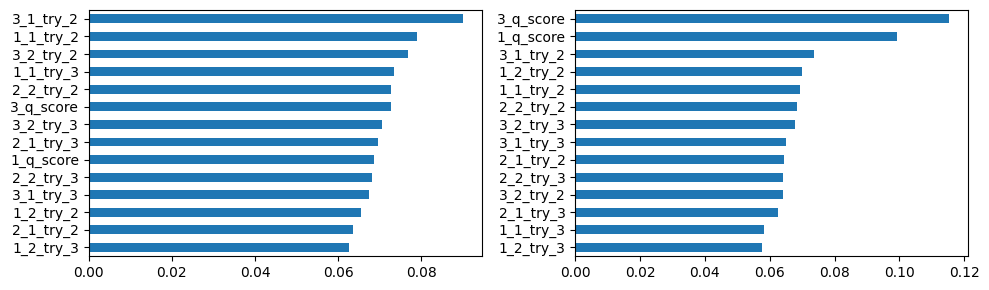

In [119]:
# Feature Importance 
fig, axes = plt.subplots(1, 2, figsize = (10, 3))

for axes, (name, model) in zip(axes, model_lst) : 
    importance = model.feature_importances_
    features = model.feature_names_in_

    imp = pd.Series(importance, index = features).sort_values()
    imp.plot.barh(ax = axes)

plt.tight_layout()
plt.show()

#### ✅  캘리포니아 집값 데이터 

In [121]:
from sklearn.datasets import fetch_california_housing
cali = fetch_california_housing()
X,y=pd.DataFrame(cali.data,columns =cali['feature_names']), pd.DataFrame(cali.target,columns =['MedHouseVal'])
#display(X.head())
#display(y.head())

#### ✅ 1.1 데이터 EDA 및 시각화

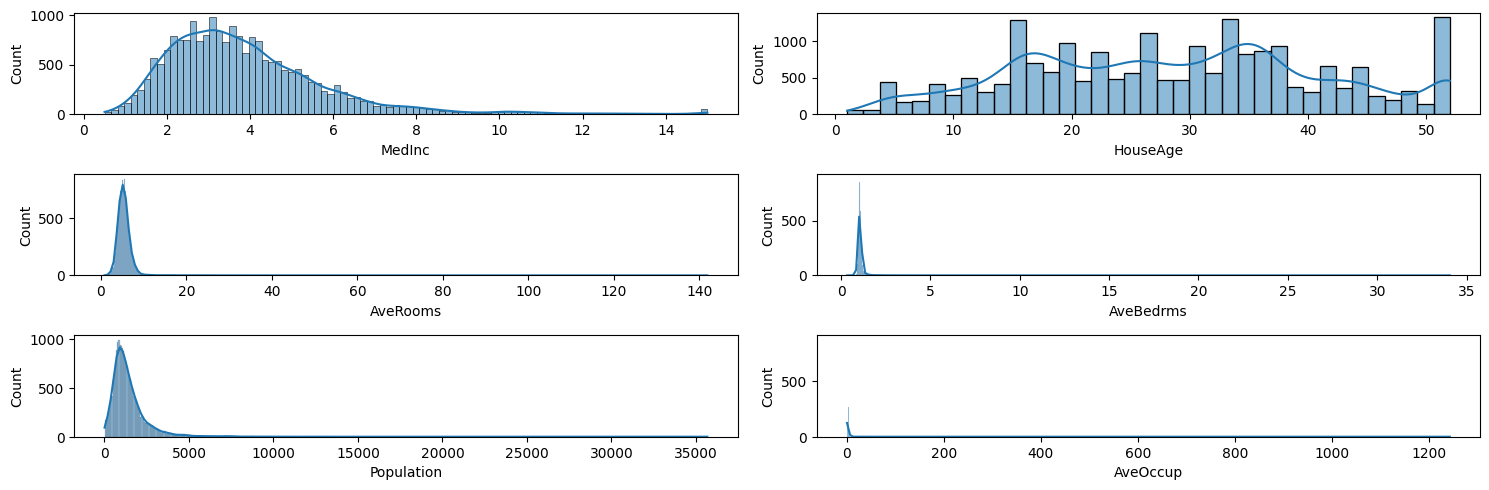

In [127]:
cols = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup'] 

fig, axes = plt.subplots(3,2, figsize = (15, 5)) 

for i, axes in enumerate(axes.flat[:len(cols)]) : 
    col_i = X[cols].columns[i]
    sns.histplot(X[col_i], kde = True, ax = axes)

plt.tight_layout()
plt.show()

#### ✅ 1.2 변수들의 다중공선성

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000


<Axes: >

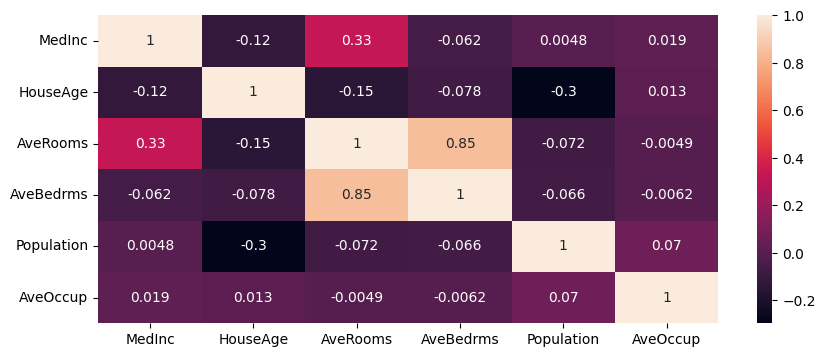

In [134]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# 1) 상관계수 
num = X.columns[:-2]
display(X[num].corr(method = 'pearson'))

plt.figure(figsize = (10,4))
sns.heatmap(X[num].corr(method = 'pearson') , annot = True)

In [140]:
vif_check = X[num]

vif = pd.DataFrame()
vif['Cols'] = vif_check.columns

vif['VIF'] = [variance_inflation_factor(vif_check.values , i) for i in range(vif_check.shape[1])]

display(vif.T)

,0,1,2,3,4,5
Cols,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup
VIF,7.766787,4.309941,41.111592,34.118257,2.322315,1.094793


#### ✅ 1.3 회귀모델을 제작할 때 다중공선성을 줄이기 위한 방법 3가지를 서술하라

In [142]:
print('''
 1. 변수 선택(Feature Selection) 
    상관계수가 높은 변수 중 하나를 제거하거나, 도메인 지식을 활용해 중요한 변수만 선택함.
    
 2. 차원 축소 (Dimensionality Reduction)
    주성분 분석(PCA), 선형 판별 분석(LDA) 등을 활용 - 저차원 변수로 변환하여 상관성을 제거하면서, 정보 손실 최소화 
    
 3. 정규화 회귀 기법 사용
    릿지 회귀 (Ridge Regression): L2 정규화를 통해 계수 크기를 제한함으로써 다중공선성 완화
    라쏘 회귀 (Lasso Regression): L1 정규화로 중요하지 않은 계수를 0으로 만들어 변수 선택 효과까지 제공.
''')


 1. 변수 선택(Feature Selection) 
    상관계수가 높은 변수 중 하나를 제거하거나, 도메인 지식을 활용해 중요한 변수만 선택함.
    
 2. 차원 축소 (Dimensionality Reduction)
    주성분 분석(PCA), 선형 판별 분석(LDA) 등을 활용 - 저차원 변수로 변환하여 상관성을 제거하면서, 정보 손실 최소화 
    
 3. 정규화 회귀 기법 사용
    릿지 회귀 (Ridge Regression): L2 정규화를 통해 계수 크기를 제한함으로써 다중공선성 완화
    라쏘 회귀 (Lasso Regression): L1 정규화로 중요하지 않은 계수를 0으로 만들어 변수 선택 효과까지 제공.



#### ✅ 1.4 Modeliing 
1. 훈련용 데이터와 평가용 데이터를 7:3으로 분리
2. 다중선형회귀모델과 엘라스틱넷모델을 통해 회귀 모델링을 진행하고 rmse값을 기준으로 평가
3. 엘라스틱넷 모델의 경우, 정규화 강도 파라미터를 2가지, l1,l2 페널티를 3가지 방식으로 조정한 모델 총 6개를 만들고 결과에 대해 분석하라

In [165]:
X1 = X.iloc[:,:6]
y 

def eval_model(name, model, X, y) : 
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3 , random_state=42)
    
    lst = []
    if name == 'LR' : 
        model.fit(x_train, y_train)
        pred = model.predict(x_test)
        MSE = mean_squared_error(y_test, pred)
        lst.append([name, MSE])

    elif name == 'Elastic' : 
        alphas = [0.1, 1.0]
        L1_ratio = [0.2, 0.5, 0.8]

        for a in alphas : 
            for L1 in L1_ratio : 
                elastic_model = ElasticNet(alpha = a , l1_ratio = L1, random_state = 42) 
                elastic_model.fit(x_train, y_train)
                pred = elastic_model.predict(x_test)
                MSE  = mean_squared_error(y_test, pred)
                lst.append([name, MSE]) 

    return lst 

all_result = []
for name, model in [['LR', LinearRegression()] , ['Elastic',None]] : 
    result = eval_model(name, model, X1, y)
    all_result.extend(result)
    
pd.DataFrame(all_result)

,0,1
0,LR,0.616443
1,Elastic,0.636319
2,Elastic,0.641017
3,Elastic,0.643629
4,Elastic,0.697903
5,Elastic,0.756293
6,Elastic,0.847557


# 통계 (40점)

### ✅ 1번 
제조회사에서는 제품의 품질을 보장하기 위해 생산 라인에서 무작위로 10개의 제품을 샘플링하여 품질 검사를 실시한다. 이때, 제품이 불량일 확률은 23%다.

(1) 적어도 3개의 제품이 불량일 확률은?
(2) 2개 이하의 제품이 불량일 확률은?

In [167]:
from scipy.stats import binom 
n = 10 
p = 0.23

rv = binom(n,p)

# 1) 적어도 3개 = 3개 이상 1 - P(X = 2)
print(1 - rv.cdf(2))

# 2) 2개 이하 제품의 불량 
print(rv.cdf(2))

0.4137172738381183
0.5862827261618817


#### ✅ 2번 
어느 고객 서비스 센터에는 센터에는 평균적으로 1분에 3건의 전화가 걸려온다. 전화 빈도는 아래와 같은 조건을 가진다.
전화가 걸려오는 사건이 독립적이다.
특정 시간 동안에 전화가 걸려올 확률이 일정하다.
단위 시간 내에 동시에 두 개 이상의 전화가 걸려올 확률은 매우 낮다.

(1) 10분 동안 전화가 23통 이하로 걸려올 확률은?
(2) 10분 동안 전화가 정확히 30통 걸려올 확률은?

In [169]:
from scipy.stats import poisson, norm 

# 1분에 3건 -> 10분이면 : 30건 
x = 30 

# 23통 이하 
print(poisson.cdf(23, x))

# 30통 
print(poisson.pmf(30, x))

0.11464591271427384
0.07263452647159181


### ✅ 3번
한 회사에서 직원들의 근무 만족도가 개선되었는지를 평가하기 위해, 직원들에게 개선 전과 개선 후의 만족도를 각각 설문조사했다. 만족도 점수는 1에서 10까지의 범위로 측정된다. 다음은 10명의 직원이 제공한 만족도 점수다

개선 전: [5, 6, 7, 5, 6, 8, 7, 5, 6, 9]      
개선 후: [6, 7, 8, 6, 7, 9, 8, 6, 7, 10]

In [174]:
before =  [5, 6, 7, 5, 6, 8, 7, 5, 6, 9]
after =  [6, 7, 8, 6, 7, 9, 8, 6, 7, 10]

from scipy.stats import wilcoxon 

stat, p_val = wilcoxon(before, after)
print(p_val)

0.001953125


### ✅ 3-1
개선 전후의 만족도가 유의미하게 변화했는지 검정하려한다. 귀무가설과 대립가설을 설정하라

In [176]:
print(f'''
귀무가설 : 개선 전, 후의 만족도가 같다.
대립가설 : 개선 전, 후의 만족도가 다르다
''')

if p_val < 0.05:
    print("✅ 유의수준 0.05에서 귀무가설을 기각 → 만족도에 유의미한 차이가 있음.")
else:
    print("⚠️ 유의수준 0.05에서 귀무가설을 기각할 수 없음 → 만족도의 차이는 유의하지 않음.")


귀무가설 : 개선 전, 후의 만족도가 같다.
대립가설 : 개선 전, 후의 만족도가 다르다

✅ 유의수준 0.05에서 귀무가설을 기각 → 만족도에 유의미한 차이가 있음.


### ✅ 4     
데이터셋 :./data/s5.csv

어느 부품공장의 1000개 부품 샘플의 무게(g)를 기록한 데이터셋이다.

In [177]:
df = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE/refs/heads/main/ADP_SET2/data/s5.csv')
df.head()

,w
0,78.8
1,72.0
2,74.9
3,81.2
4,79.3


이 데이터에서 183개의 샘플을 추출했을 때 샘플 무게의 평균이 69.5g에서 70.1g 사이에 있을 확률을 구하여라

In [181]:
from scipy.stats import norm

x = df['w'].mean()
std = df['w'].std()
n = 183

se = std / np.sqrt(n)

norm.cdf(70.1, loc = x, scale = se) - norm.cdf(69.5, loc = x, scale = se) 

np.float64(0.5876910371573985)